In [61]:
# Zhen - Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [62]:
# Zhen - Load TTC subway delay data and weather data
ttc_delays_path = 'ttc-subway-delay-data-2023.csv'
delay_codes_path = 'ttc-subway-delay-codes.csv'
weather_data_path = 'weatherstats_toronto_daily.csv'

In [63]:
ttc_delays = pd.read_csv(ttc_delays_path)
delay_codes = pd.read_csv(delay_codes_path)
weather_data = pd.read_csv(weather_data_path)


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[TTC Subway Map](ttc-subway-map.png)'


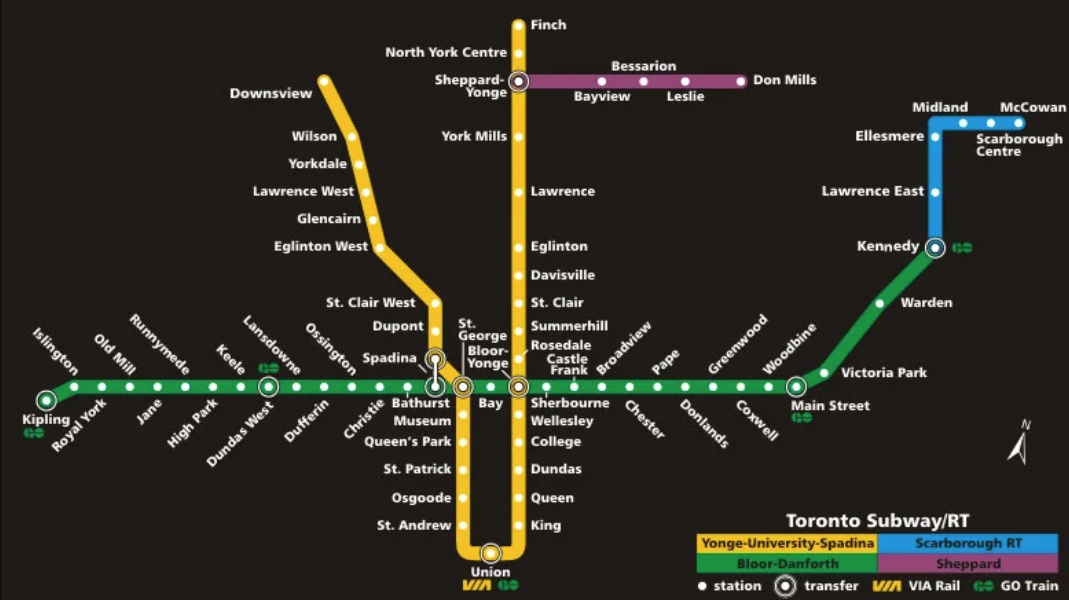

In [84]:
#Zhen - Display TTC subway map
![TTC Subway Map](ttc-subway-map.png)
from IPython.display import Image, display

display(Image(filename='ttc-subway-map.png'))

In [64]:
# Zhen - Clean column names in the delay_codes dataset
delay_codes.columns = delay_codes.columns.str.strip()  # Remove leading/trailing whitespace
delay_codes.columns = delay_codes.columns.str.upper()  # Standardize to uppercase for consistency

# Clean and rename relevant columns in delay codes
delay_codes_cleaned = delay_codes[['SUB RMENU CODE', 'CODE DESCRIPTION']].rename(
    columns={'SUB RMENU CODE': 'CODE', 'CODE DESCRIPTION': 'DESCRIPTION'}
).drop_duplicates()

# Check for missing or duplicate values in the TTC delays dataset
print("Missing values in TTC delays dataset:")
print(ttc_delays.isnull().sum())

# Remove duplicate rows from TTC delays dataset
ttc_delays_cleaned = ttc_delays.drop_duplicates()

# Preview cleaned datasets
print(delay_codes_cleaned.head())  # Preview cleaned delay codes
print(ttc_delays_cleaned.head())  # Preview cleaned TTC delays


Missing values in TTC delays dataset:
Date            0
Time            0
Day             0
Station         0
Code            0
Min Delay       0
Min Gap         0
Bound        8526
Line           48
Vehicle         0
dtype: int64
    CODE          DESCRIPTION
0   EUAC     Air Conditioning
1   EUAL  Alternating Current
2  EUATC   ATC RC&S Equipment
3   EUBK               Brakes
4   EUBO                 Body
         Date  Time     Day           Station   Code  Min Delay  Min Gap  \
0  2023-01-01  2:22  Sunday    MUSEUM STATION  MUPAA          3        9   
1  2023-01-01  2:30  Sunday   KIPLING STATION   MUIS          0        0   
2  2023-01-01  2:33  Sunday    WARDEN STATION    SUO          0        0   
3  2023-01-01  3:17  Sunday     KEELE STATION   MUIS          0        0   
4  2023-01-01  7:16  Sunday  BATHURST STATION   MUIS          0        0   

  Bound Line  Vehicle  
0     S   YU     5931  
1     E   BD     5341  
2     W   BD        0  
3   NaN   BD        0  
4   NaN   BD

In [65]:
ttc_merged = ttc_delays.merge(
    delay_codes_cleaned, how='left', left_on='Code', right_on='CODE'
).drop(columns=['CODE'])

In [66]:
# Zhen - Extract hour from the 'Time' column for time-of-day analysis
ttc_merged['Hour'] = pd.to_datetime(ttc_merged['Time'], errors='coerce').dt.hour

<ipython-input-66-0d5e4fa0b19f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc_merged['Hour'] = pd.to_datetime(ttc_merged['Time'], errors='coerce').dt.hour


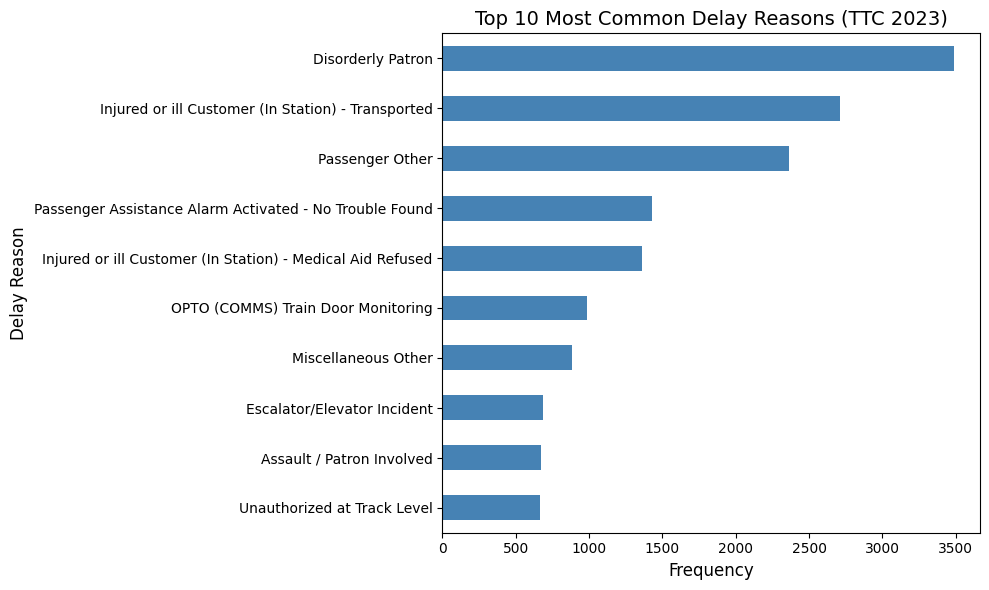

In [67]:
# Zhen - Count and visualize the most common delay reasons
top_delay_reasons = (
    ttc_merged['DESCRIPTION']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  # Sort for better visualization
)

# Plot the top 10 delay reasons
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_delay_reasons.plot(kind='barh', color='steelblue')
plt.title('Top 10 Most Common Delay Reasons (TTC 2023)', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Delay Reason', fontsize=12)
plt.tight_layout()
plt.show()

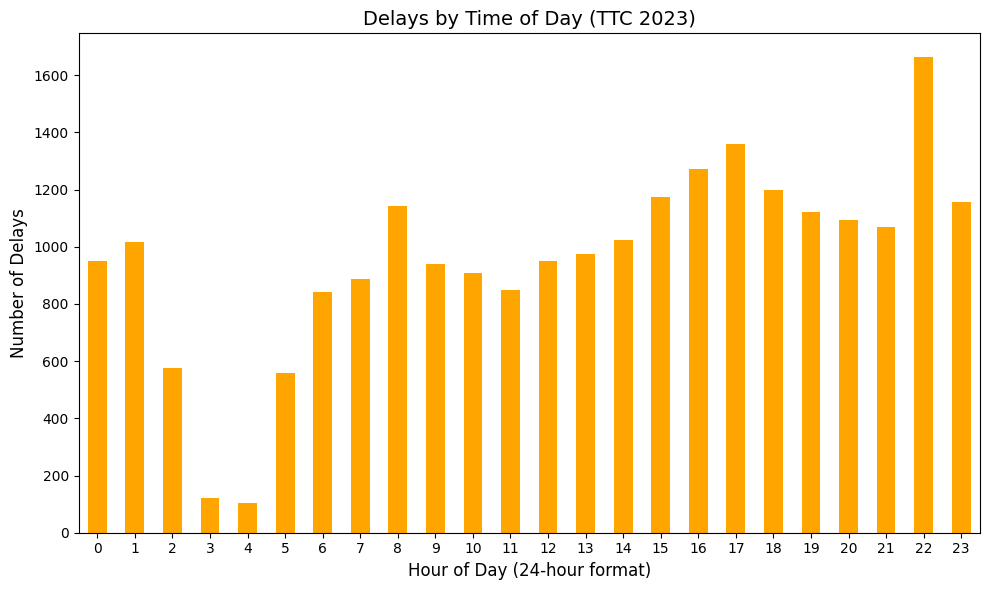

In [68]:
# Zhen - Bar Chart: Delays by Time of Day
time_of_day_delays = ttc_merged.groupby('Hour').size()
plt.figure(figsize=(10, 6))
time_of_day_delays.plot(kind='bar', color='orange')
plt.title('Delays by Time of Day (TTC 2023)', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

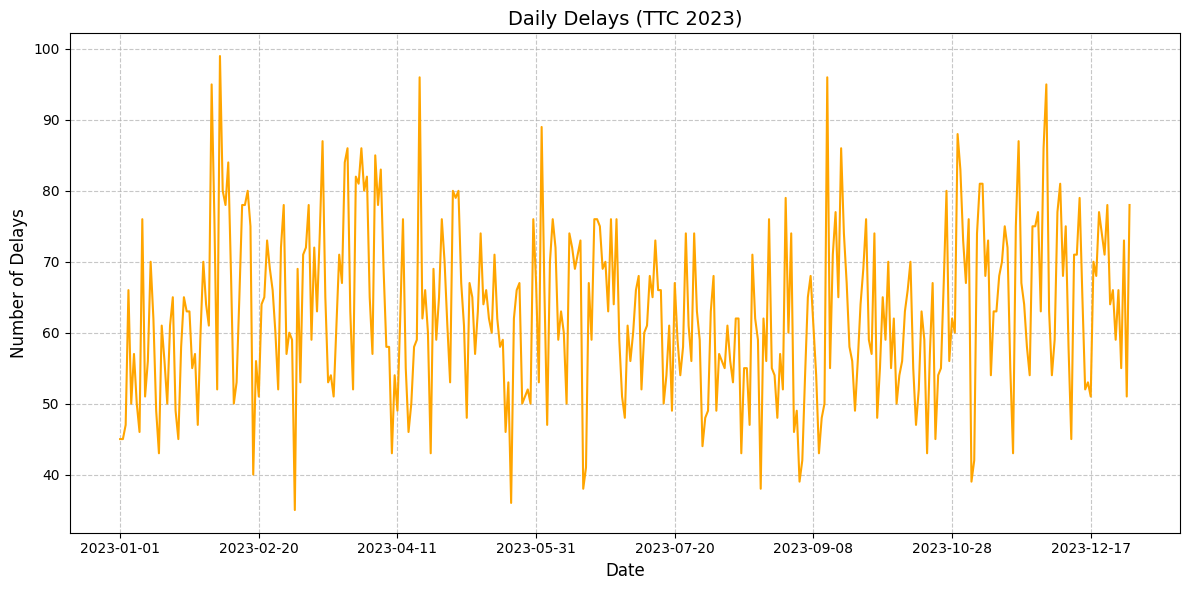

In [69]:
# Zhen - Bar Chart delays by day
daily_delays = ttc_merged.groupby(ttc_merged['Date']).size()

# Plot daily delays
plt.figure(figsize=(12, 6))
daily_delays.plot(kind='line', color='orange')
plt.title('Daily Delays (TTC 2023)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


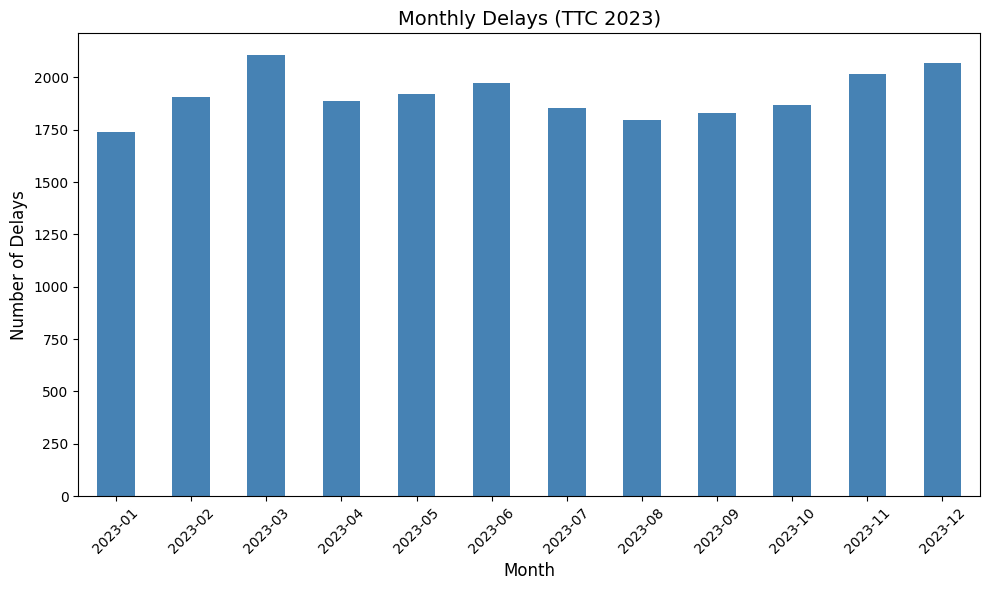

In [70]:
# Zhen - Bar Chart delays by month
ttc_merged['Date'] = pd.to_datetime(ttc_merged['Date'], errors='coerce')

monthly_delays = ttc_merged.groupby(ttc_merged['Date'].dt.to_period('M')).size()

# Plot monthly delays
plt.figure(figsize=(10, 6))
monthly_delays.plot(kind='bar', color='steelblue')
plt.title('Monthly Delays (TTC 2023)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


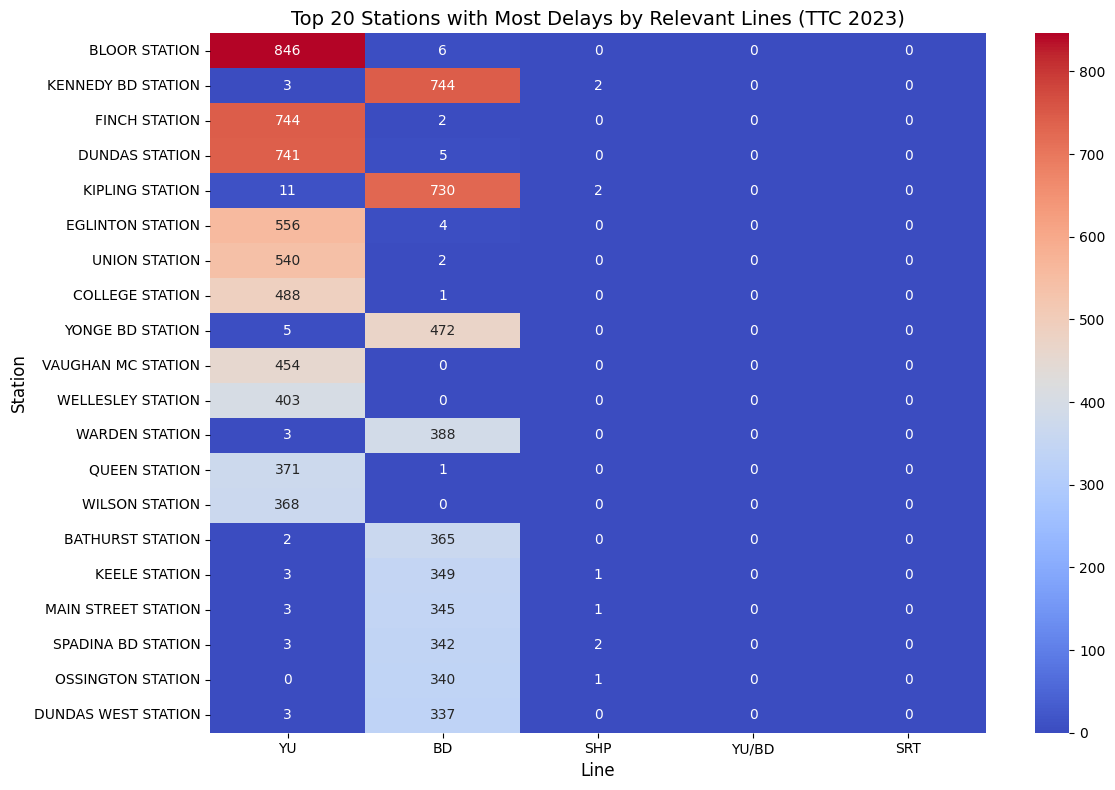

In [71]:
# Zhen - Heatmap: Top 20 Stations with Most Delays by Line
station_line_delays = ttc_merged.groupby(['Station', 'Line']).size().unstack(fill_value=0)

# Sort stations by total delays
station_line_delays_sorted = station_line_delays.loc[
    station_line_delays.sum(axis=1).sort_values(ascending=False).index
]

# Filter the data to include only the relevant lines
filtered_lines = ['YU', 'BD', 'SHP', 'YU/BD', 'SRT']
filtered_station_line_delays = station_line_delays_sorted[filtered_lines]

# Limit to top 20 stations for readability
filtered_top_stations = filtered_station_line_delays.head(20)

# Plot the refined heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_top_stations, cmap="coolwarm", annot=True, fmt="d", cbar=True)
plt.title('Top 20 Stations with Most Delays by Relevant Lines (TTC 2023)', fontsize=14)
plt.xlabel('Line', fontsize=12)
plt.ylabel('Station', fontsize=12)
plt.tight_layout()
plt.show()




In [72]:
# Zhen - Prepare weather data for merging
weather_data_cleaned = weather_data[['date', 'avg_temperature', 'max_temperature', 'min_temperature',
                                     'avg_hourly_relative_humidity', 'max_relative_humidity', 'precipitation']]
weather_data_cleaned.rename(columns={
    'date': 'Date',
    'avg_temperature': 'Avg Temperature',
    'max_temperature': 'Max Temperature',
    'min_temperature': 'Min Temperature',
    'avg_hourly_relative_humidity': 'Avg Humidity',
    'max_relative_humidity': 'Max Humidity',
    'precipitation': 'Precipitation'
}, inplace=True)
weather_data_cleaned['Date'] = pd.to_datetime(weather_data_cleaned['Date'], errors='coerce')
ttc_merged['Date'] = pd.to_datetime(ttc_merged['Date'], errors='coerce')


<ipython-input-72-426884d36ff6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_cleaned.rename(columns={
<ipython-input-72-426884d36ff6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_cleaned['Date'] = pd.to_datetime(weather_data_cleaned['Date'], errors='coerce')


In [73]:
# Zhen - Merge weather data with TTC delays
daily_delays = ttc_merged.groupby('Date').size().rename('Number of Delays')
daily_weather_delays = weather_data_cleaned.merge(daily_delays, on='Date', how='inner')

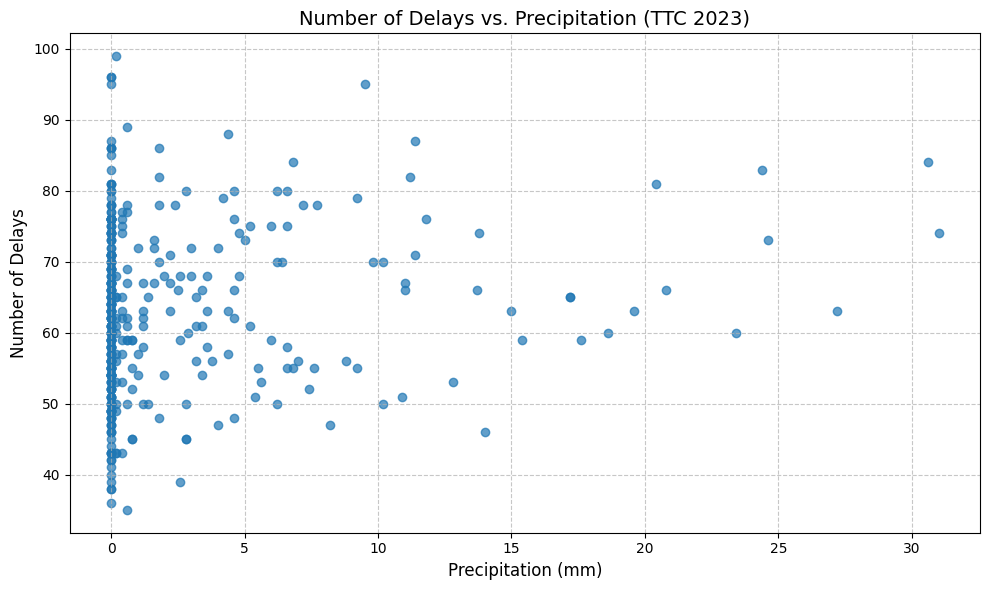

In [74]:
# Zhen - Scatter Plots: Delays vs. Weather Variables
# Delays vs. Precipitation
plt.figure(figsize=(10, 6))
plt.scatter(daily_weather_delays['Precipitation'], daily_weather_delays['Number of Delays'], alpha=0.7)
plt.title('Number of Delays vs. Precipitation (TTC 2023)', fontsize=14)
plt.xlabel('Precipitation (mm)', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

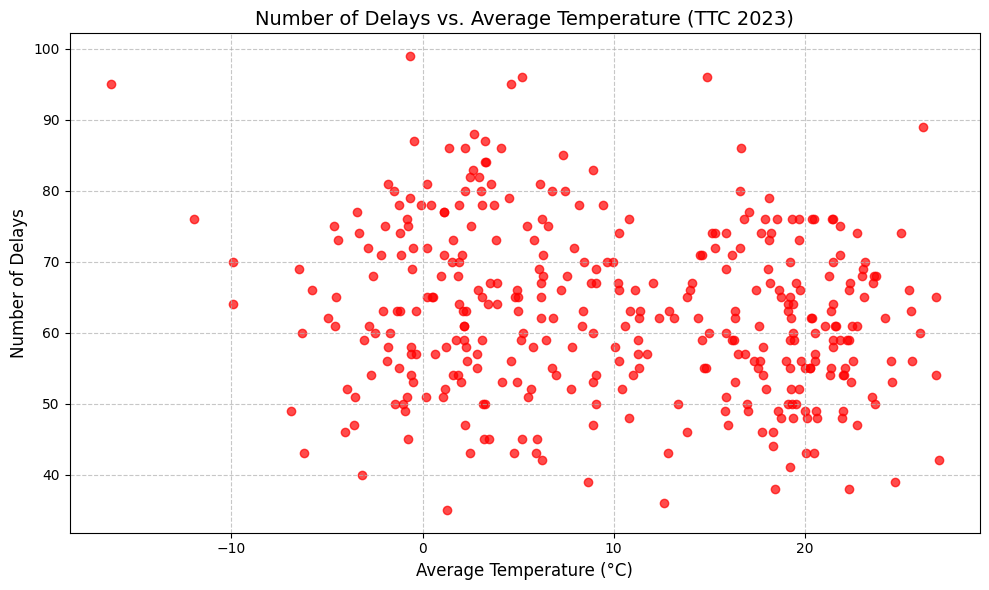

In [75]:
# Zhen - Delays vs. Average Temperature
plt.figure(figsize=(10, 6))
plt.scatter(daily_weather_delays['Avg Temperature'], daily_weather_delays['Number of Delays'], alpha=0.7, color='red')
plt.title('Number of Delays vs. Average Temperature (TTC 2023)', fontsize=14)
plt.xlabel('Average Temperature (°C)', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

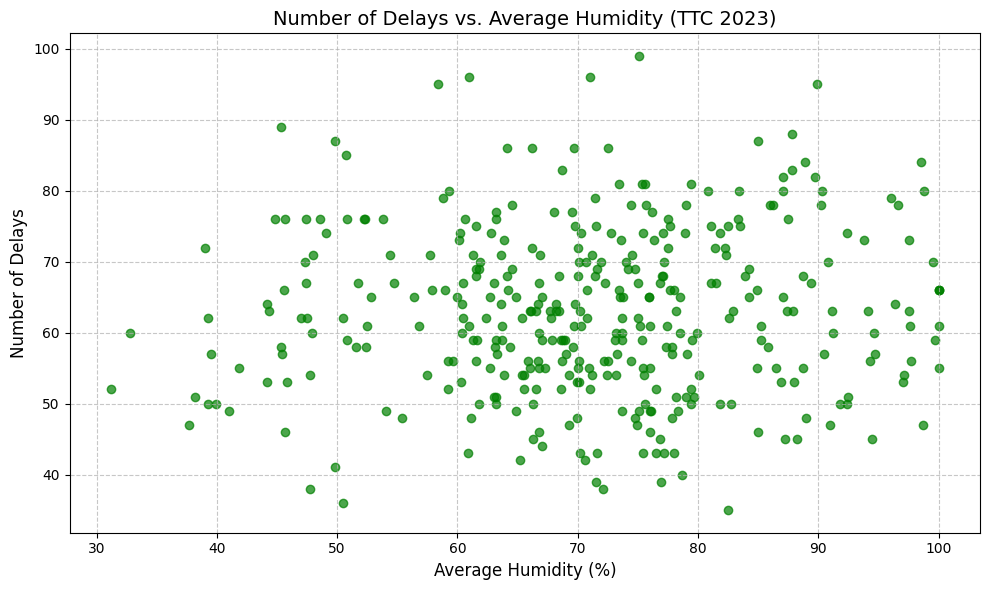

In [76]:
# Zhen - Delays vs. Average Humidity
plt.figure(figsize=(10, 6))
plt.scatter(daily_weather_delays['Avg Humidity'], daily_weather_delays['Number of Delays'], alpha=0.7, color='green')
plt.title('Number of Delays vs. Average Humidity (TTC 2023)', fontsize=14)
plt.xlabel('Average Humidity (%)', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [77]:
# Zhen - Regression Analysis
X = daily_weather_delays[['Precipitation', 'Avg Temperature', 'Avg Humidity']]
y = daily_weather_delays['Number of Delays']
X_cleaned = X.dropna()
y_cleaned = y[X_cleaned.index]

# Fit separate regression models for each weather variable
regression_results = {}
for col in X_cleaned.columns:
    model = LinearRegression()
    model.fit(X_cleaned[[col]], y_cleaned)
    regression_results[col] = {
        'Coefficient': model.coef_[0],
        'Intercept': model.intercept_,
        'R-squared': model.score(X_cleaned[[col]], y_cleaned)
    }

# Convert regression results to a DataFrame for display
regression_results_df = pd.DataFrame(regression_results).T
regression_results_df.rename(columns={'Coefficient': 'Slope', 'Intercept': 'Y-Intercept'}, inplace=True)

# Display the regression results using pandas
print("Regression Results for Weather Variables:")
print(regression_results_df)


Regression Results for Weather Variables:
                    Slope  Y-Intercept  R-squared
Precipitation    0.355860    62.064936   0.022848
Avg Temperature -0.228434    65.217140   0.032500
Avg Humidity     0.044111    59.769764   0.002828
